# Data for good - Projet demande de financement avec IA

## Import des bibliothèques

In [17]:
from langchain.document_loaders import PyPDFLoader, Docx2txtLoader
import os
import re

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain import hub
from langchain_openai import ChatOpenAI

from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate

## Traitement de l 'AAP

### Chargement de l AAP

In [18]:
def extract_content_text(file_path):
    """
    Permet d'extraire le contenu d'un fichier PDF ou Word sous forme de liste.
    """
    ext = os.path.splitext(file_path)[-1].lower()
    all_pages_content = []
    
    if ext == ".pdf":
        pdf_loader = PyPDFLoader(file_path)
        documents = pdf_loader.load()
        all_pages_content = [page.page_content for page in documents]
    elif ext == ".docx":
        docx_loader = Docx2txtLoader(file_path)
        documents = docx_loader.load()
        all_pages_content = [page.page_content for page in documents]
    else:
        raise ValueError("Format de fichier non pris en charge. Veuillez fournir un fichier PDF ou DOCX.")
    
    return all_pages_content

file_path = "./Exemple_ESF_P01_AAP3.pdf" 
doc_content = extract_content_text(file_path)
print(doc_content)

['1 \n \nNote d’intention \nDate limite de dépôt : 3 avril 2023 \n \n \n \nIDENTITE DE LA STRUCTURE \nNom :          \nAdresse :  \nTéléphone  Site internet:  \n \n \nPRESENTATION DE LA STRUCTURE \nRaison d’être / Principales activités : \nStatut (Association loi 1901, Fondation, autre) :  \nDate de création :  \nBudget annuel 2022 :  \nNombre de collaborateurs :  \nNombre de bénévoles :  \nNombre d’adhérents :  \n \nCONTACT POUR CET APPEL A PROJETS \nNom – Prénom :   Fonction :  \nTéléphone:  E-mail :  \n \n \n \n<projectQuestion> Quel est le nom du projet ?   </projectQuestion> \nStructure porteuse du projet \nLe projet', '2 \n \n<projectQuestion> Où a lieu le projet présenté ?  </projectQuestion> \n \n \n<projectQuestion> Présentez le projet en 50 mots</projectQuestion> \n \n<projectQuestion>  Quels sont les Objectifs du projet et résultats attendus : </projectQuestion> \n<projectQuestion> Quels seront les Publics bénéficiaires (profil, nombre et implication dans le projet) : \n</pr

### Identification des questions de l'AAP

In [19]:
def extract_questions(pages_content):
  """ Permet d extraire des listes les questions relatives au projet ou spécifique identifiées par les tag"""
  all_questions = []
  for page_content in pages_content:
      pattern = r"<projectQuestion>(.+?)</projectQuestion>"
      questions = re.findall(pattern, page_content, re.DOTALL)
      all_questions.extend([q.strip() for q in questions])
  return all_questions

questions = extract_questions(doc_content)
for idx, question in enumerate(questions, 1):
    print(f"{idx}. {question}")

1. Quel est le nom du projet ?
2. Où a lieu le projet présenté ?
3. Présentez le projet en 50 mots
4. Quels sont les Objectifs du projet et résultats attendus :
5. Quels seront les Publics bénéficiaires (profil, nombre et implication dans le projet) :
6. Quelles principales actions avez-vous prévues ?
7. Avez-vous des partenaires engagés dans le projet ?
8. Quelle est la durée estimé de ce projet et calendrier prévisionnel ?


## Traitement du PP

### Chargement du PP

In [5]:
pdf_path='./Exemple_Fiche projet fictive - scolarite.pdf'
loader = PyPDFLoader(pdf_path)
docs = loader.load() # nous avons cette fois un format Documents et pas un txt 


In [6]:
print(docs[0].page_content[:500]) # accès au txt avec .page_content

FICHE PROJET – Lutte contre le décrochage scolaire à Rueil-Malmaison 
1- Nom du projet :  
"Réussite pour Tous : Accompagnement et Remobilisation Scolaire" 
2- Contexte, constat enjeux et du projet : 
Le décrochage scolaire est un enjeu majeur à Rueil-Malmaison, touchant particulièrement les 
jeunes issus de milieux socio-économiques défavorisés ou en difficulté d'apprentissage. Selon 
les données de l'Éducation nationale, une proportion significative d'élèves décrochent avant 
l'obtention d'un 


### Splitting du PP

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  
    chunk_overlap=200, 
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Le document a été splitté en {len(all_splits)} sous documents.")

Le document a été splitté en 5 sous documents.


### Définition de l'embedding

In [8]:
api_key=os.getenv("OPENAI_API_KEY")

In [9]:
embeddings = OpenAIEmbeddings(api_key=api_key)

### Définition du vector_store

In [10]:
vector_store = InMemoryVectorStore(embeddings)

### Ajout des documents au vector_store

In [11]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['4bce5398-c56f-4514-8506-da9e744bd894', 'f333bade-a4dd-489d-aa40-7a9762029f4b', 'fd446426-bb3c-4cca-ae5e-bb692518d13c']


## Mise en place du RAG

### Création du prompt template

In [12]:
# Prompt template disponible sur le hub

prompt = hub.pull("rlm/rag-prompt") 

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [22]:
# prompt template personnalisé

template = """Tu es chargé de projet pour une association. Ta mission est de répondre à des appels à projets. 
    Tu dois répondre à des {question} en utilisant les documents de contexte qui te sont donnés. 
    Si tu ne connais pas la réponse, dis juste que tu ne sais pas, n'essaye pas de répondre absolument. 
    Sois clair et précis. 
    
    Context : {context} 
    Question : {question} 
    Réponse utile :
    """

custom_rag_prompt = PromptTemplate.from_template(template)

example_response = custom_rag_prompt.format(
    context="(contexte présenté ici)", 
    question="(question de l AAP)"
)

print(example_response)

Tu es chargé de projet pour une association. Ta mission est de répondre à des appels à projets. 
    Tu dois répondre à des (question de l AAP) en utilisant les documents de contexte qui te sont donnés. 
    Si tu ne connais pas la réponse, dis juste que tu ne sais pas, n'essaye pas de répondre absolument. 
    Sois clair et précis. 

    Context : (contexte présenté ici) 
    Question : (question de l AAP) 
    Réponse utile :
    


### Définition du graph et du llm utilisé

In [13]:
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

In [14]:
## State

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## Nodes

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

## Control Flow

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

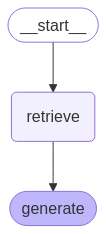

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Essai de requête sur le graph

In [23]:
result = graph.invoke({"question": "Où se passe le projet?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='2b66ce95-ddb9-4372-b025-33184256f29e', metadata={'producer': 'Microsoft: Print To PDF', 'creator': 'PyPDF', 'creationdate': '2025-02-16T12:35:35+01:00', 'author': '', 'moddate': '2025-02-16T12:35:35+01:00', 'title': 'Microsoft Word - Fiche projet fictive - scolarite', 'source': './Exemple_Fiche projet fictive - scolarite.pdf', 'total_pages': 2, 'page': 1, 'page_label': '2', 'start_index': 852}, page_content="scolaires, missions locales et entreprises pour proposer des parcours adaptés aux \njeunes. \n6- Bénéficiaires du projet : \n\uf0b7 Public cible : Jeunes de 12 à 18 ans identifiés comme étant en situation de décrochage \nscolaire ou en risque de décrochage. \n\uf0b7 Bénéficiaires indirects : Familles des jeunes accompagnés, établissements scolaires \net enseignants, entreprises et acteurs locaux bénéficiant d'une main-d'œuvre mieux \nformée et insérée. \nCe projet vise à redonner confiance aux jeunes en difficulté, à leur offrir un cadre structurant \net bien

In [25]:
result2 = graph.invoke({"question": "A qui va bénéficier ce projet?"})

print(f'Answer: {result2["answer"]}')

Answer: Ce projet bénéficiera principalement aux jeunes de 12 à 18 ans en situation de décrochage scolaire ou à risque de l'être. Les familles de ces jeunes, ainsi que les établissements scolaires et les entreprises locales, tireront également profit d'une main-d'œuvre mieux formée et intégrée. L'objectif est de redonner confiance aux jeunes en difficulté et de les orienter vers des formations ou un emploi.


In [28]:
for idx, question in enumerate(questions, 1):
    print(f"{idx}. {question}")
    print(f'Answer: {graph.invoke({"question": question})["answer"]}')

1. Quel est le nom du projet ?
Answer: Le nom du projet est "Réussite pour Tous : Accompagnement et Remobilisation Scolaire".
2. Où a lieu le projet présenté ?
Answer: Le projet présenté a lieu à Rueil-Malmaison. Il vise à réduire le taux de décrochage scolaire en proposant un accompagnement aux jeunes en difficulté. Les activités incluent des ateliers de remobilisation, du mentorat, et des stages professionnels.
3. Présentez le projet en 50 mots
Answer: Le projet vise à prévenir le décrochage scolaire chez les jeunes de 12 à 18 ans en proposant un accompagnement personnalisé. Cela inclut des ateliers de remobilisation, du mentorat, des immersions professionnelles et l'implication des familles et des acteurs locaux. L'objectif est de renforcer la confiance en soi et d'orienter les jeunes vers la réussite éducative et professionnelle.
4. Quels sont les Objectifs du projet et résultats attendus :
Answer: Les objectifs du projet sont de réduire le taux de décrochage scolaire à Rueil-Malma

### Compléments

In [48]:
# Stream steps

for step in graph.stream(
    {"question": "Where does the project take place?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='fbb51a4c-9873-40aa-8e06-d565e7887c70', metadata={'producer': 'Microsoft: Print To PDF', 'creator': 'PyPDF', 'creationdate': '2025-02-16T12:35:35+01:00', 'author': '', 'moddate': '2025-02-16T12:35:35+01:00', 'title': 'Microsoft Word - Fiche projet fictive - scolarite', 'source': './Exemple_Fiche projet fictive - scolarite.pdf', 'total_pages': 2, 'page': 1, 'page_label': '2', 'start_index': 852}, page_content="scolaires, missions locales et entreprises pour proposer des parcours adaptés aux \njeunes. \n6- Bénéficiaires du projet : \n\uf0b7 Public cible : Jeunes de 12 à 18 ans identifiés comme étant en situation de décrochage \nscolaire ou en risque de décrochage. \n\uf0b7 Bénéficiaires indirects : Familles des jeunes accompagnés, établissements scolaires \net enseignants, entreprises et acteurs locaux bénéficiant d'une main-d'œuvre mieux \nformée et insérée. \nCe projet vise à redonner confiance aux jeunes en difficulté, à leur offrir un cadre struc

In [49]:
# Stream tokens

for message, metadata in graph.stream(
    {"question": "Where does the project take place?"}, stream_mode="messages"
):
    print(message.content, end="|")

|The| project| takes| place| in| R|ueil|-M|alma|ison|.| It| aims| to| address| the| issue| of| school| dropout| among| young| people| in| that| area|.| Activities| include| workshops|,| mentorship|,| and| partnerships| with| local| schools| and| businesses|.||